In [27]:
!pip3 install tensorflow
!pip3 install tensorflow-gpu
!pip3 install opencv-python
!pip3 install matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/1v/1ywp4xjx1y116392trcjdvd00000gn/T/pip-install-9p327gpc/tensorflow-gpu_948ad5716b3d442ea6956a5df5b6b18d/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: p

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
plt.imshow??

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    *,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
    **kwargs,
)
Docstring:
Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image set up the colormapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

The number of pixels used to render an image is set by the Axes size
and the *dpi* of the figure. This can lead to aliasing artifacts when
the image is resampled because the displayed image size will usually
not match the size of *X* (see
:doc:`/gallery/images_contours_and_fields/image_antialiasing`).
The resampling can be controlled via the *interpolation* parameter
and/or :rc:`imag

In [4]:
#import tensorflow dependencies - functional API
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
 

In [6]:
#setup gpu
#limit how much vram can use avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices("gpu")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
for gpu in gpus:
    print(gpu)

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
POS_PATH

'data/positive'

In [10]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [1]:
#uncompress the tar file of faces in the wild dataset

!tar -xf lfw.tgz

In [12]:
#put our pics in the right folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH =  os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [34]:
#import uuid library to give unique names to each of our images collected
import uuid

collect images


In [37]:
# '{}.jpg'.format(uuid.uuid1())#test!

'18b7a1a8-4393-11ef-90ac-5a61087f7887.jpg'

In [38]:
#set up connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #slice x, y, and color channel axis to create 250x250 pixel image
    frame = frame[350:350+250,950:950+250, :]

    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    #show image back to screen
    cv2.imshow('Image Collection', frame)
    #Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



In [ ]:
cv2.waitKey??

Docstring:
waitKey([, delay]) -> retval
.   @brief Waits for a pressed key.
.   
.   The function waitKey waits for a key event infinitely (when \f$\texttt{delay}\leq 0\f$ ) or for delay
.   milliseconds, when it is positive. Since the OS has a minimum time between switching threads, the
.   function will not wait exactly delay ms, it will wait at least delay ms, depending on what else is
.   running on your computer at that time. It returns the code of the pressed key or -1 if no key was
.   pressed before the specified time had elapsed. To check for a key press but not wait for it, use
.   #pollKey.
.   
.   @note The functions #waitKey and #pollKey are the only methods in HighGUI that can fetch and handle
.   GUI events, so one of them needs to be called periodically for normal event processing unless
.   HighGUI is used within an environment that takes care of event processing.
.   
.   @note The function only works if there is at least one HighGUI window created and the window is


: 

load and preprocess images


In [6]:
#use *wildcard to grab all files in anc_path with jpg file type. can use this with any file type compatible with tf
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
#see what it does
dir_test.next()

b'data/anchor/dc61c9ee-4393-11ef-90ac-5a61087f7887.jpg'

scale and resize    

In [9]:
def preprocess(file_path):
    #read in image from file path and assign to new variable
    byte_img = tf.io.read_file(file_path)
    #load in image and decode jpeg
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing steps - resize image to 100, 100 pixels, 3 channels
    img = tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1... this takes every pixel value from original of 0-255 and makes it 0-1
    img = img / 255.0
    return img

In [10]:
img = preprocess("data/anchor/d9702762-4393-11ef-90ac-5a61087f7887.jpg")

In [11]:
img.numpy().min(), img.numpy().max()

(0.024019608, 0.8507353)

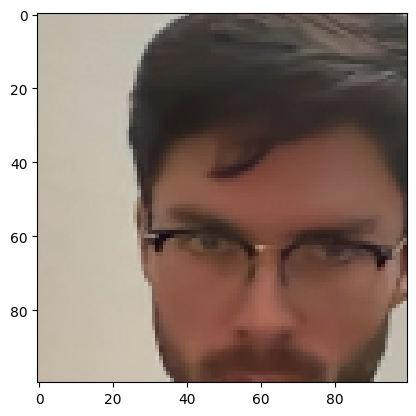

In [12]:
plt.imshow(img)

Create labeled dataset


In [13]:
#we want to create positive and negative examples
#anchor and positive = 1
#anchor and negative = 0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()

In [15]:
# look at a single sample 
example = samples.next()

build train and test partition

In [16]:
def preprocess_twin(input_img, val_img, label):
    return(preprocess(input_img), preprocess(val_img), label)

In [17]:
res = preprocess_twin(*example)

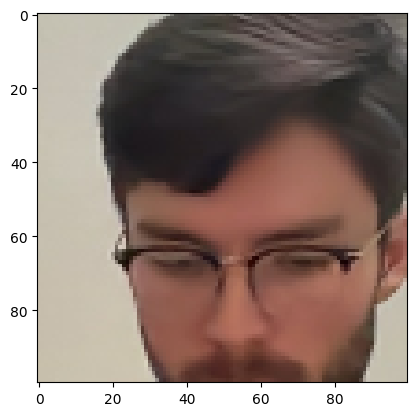

In [18]:
len(res)
plt.imshow(res[1])

In [19]:
res[2]

1.0

In [20]:
#dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
len(samples.next())

3

In [23]:
samp = samples.next()

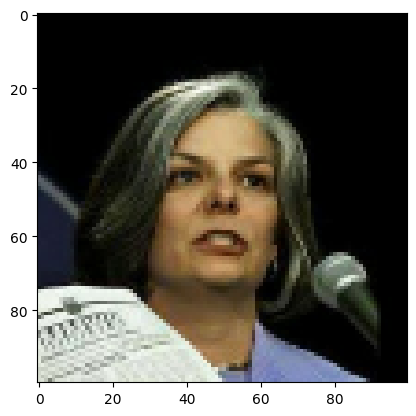

In [24]:
plt.imshow(samp[1])

In [25]:
samp[2]

0.0

In [26]:
round(len(data))

600

In [27]:
#train test split
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [152]:
train_data
#now our format is different betcause we are batching by 16 datapoints

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [28]:
train_samples = train_data.as_numpy_iterator()


In [29]:
train_sample = train_samples.next()

In [30]:
len(train_sample[0])

16

In [31]:
train_sample[0]

array([[[[0.44460785, 0.40931374, 0.3897059 ],
         [0.24583334, 0.2125    , 0.18995099],
         [0.24338235, 0.2247549 , 0.19044118],
         ...,
         [0.74509805, 0.74509805, 0.7137255 ],
         [0.74509805, 0.74509805, 0.7137255 ],
         [0.7558824 , 0.7441176 , 0.7088235 ]],

        [[0.24166666, 0.20637254, 0.18480392],
         [0.26887256, 0.23700981, 0.20784314],
         [0.23161764, 0.2122549 , 0.18014705],
         ...,
         [0.7561275 , 0.7561275 , 0.7247549 ],
         [0.75      , 0.75      , 0.71862745],
         [0.75686276, 0.74509805, 0.7176471 ]],

        [[0.27083334, 0.23553921, 0.20808823],
         [0.25784314, 0.23186274, 0.20196079],
         [0.20049019, 0.1870098 , 0.15980393],
         ...,
         [0.7529412 , 0.7529412 , 0.72156864],
         [0.7529412 , 0.7529412 , 0.72156864],
         [0.7637255 , 0.7519608 , 0.7245098 ]],

        ...,

        [[0.8039216 , 0.76862746, 0.7019608 ],
         [0.8068628 , 0.7732843 , 0.7031863 ]

In [32]:
#test partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))

In [33]:
len(test_data)

180

In [34]:
len(train_data)

27

## BUILD our siamese NN

### Build our embedding layer

In [ ]:
def make_embedding():
    inp = Input(shape=(100,100,3)) #100 X 100 pixels, 3 color channels

    #convolution takes the number of filters we want to pass through, sometimes we would specify stride, which tells how many pixels to traverse
    #at a time.
    c1 = Conv2D(64, (10,10), activation='relu')(inp) #64 filters, shape 10 x 10 pixels, relu activation, passing input to the layer
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) #we take max value from 2x2 area

    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)




    return Model(inputs=, outputs, name=)